In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.special import erfi

In [3]:
R4PI = np.sqrt(4.0*np.pi)

def summand(x=1.5, nvec_arr=np.array([[0,0,0]]), alpha=1.0):
    rSQ_arr = (nvec_arr**2).sum(1)
    Ds = rSQ_arr-x
    return np.exp(-alpha*Ds)/Ds

def summand_der(x=1.5, nvec_arr=np.array([[0,0,0]]), alpha=1.0):
    rSQ_arr = (nvec_arr**2).sum(1)
    Ds = rSQ_arr-x
    return np.exp(-alpha*Ds)/Ds**2+alpha*np.exp(-alpha*Ds)/Ds

def T1(x=1.5, cut=3, alpha=1.0):
    rng = range(-cut, cut+1)
    mesh = np.meshgrid(*([rng]*3))
    nvec_arr = np.vstack([y.flat for y in mesh]).T
    return np.sum(summand(x, nvec_arr, alpha))/R4PI

def T1_der(x=1.5, cut=3, alpha=1.0):
    rng = range(-cut, cut+1)
    mesh = np.meshgrid(*([rng]*3))
    nvec_arr = np.vstack([y.flat for y in mesh]).T
    return np.sum(summand_der(x, nvec_arr, alpha))/R4PI

def T2(x=1.5, alpha=1.0):
    if x >= 0:
        ttmp = 2.0*(np.pi**2)*np.sqrt(x)\
                * erfi(np.sqrt(alpha*x))\
                - 2.0*np.exp(alpha*x)\
                * np.sqrt(np.pi**3)/np.sqrt(alpha)
    else:
        ttmp = -2.0*(np.pi**2)*np.sqrt(-x)\
                * erf(np.sqrt(-alpha*x))\
                - 2.0*np.exp(alpha*x)\
                * np.sqrt(np.pi**3)/np.sqrt(alpha)
    return ttmp/R4PI

def T2_der(x=1.5, alpha=1.0):
    if x >= 0:
        ttmp = (np.pi**2)/np.sqrt(x)\
                * erfi(np.sqrt(alpha*x))\
                + (np.pi**2)*np.sqrt(alpha)\
                * (2/np.sqrt(np.pi))*np.exp(alpha*x)\
                - 2.0*alpha*np.exp(alpha*x)\
                * np.sqrt(np.pi**3)/np.sqrt(alpha)
    else:
        ttmp = (np.pi**2)/np.sqrt(-x)\
                * erf(np.sqrt(-alpha*x))\
                + (np.pi**2)*np.sqrt(alpha)\
                * (2/np.sqrt(np.pi))*np.exp(alpha*x)\
                - 2.0*alpha*np.exp(alpha*x)\
                * np.sqrt(np.pi**3)/np.sqrt(alpha)
    return ttmp/R4PI

In [4]:
def zeta_function(x=1.5, cut=3, alpha=1.0):
    return T1(x=x, cut=cut, alpha=alpha)\
            + T2(x=x, alpha=alpha)
def zeta_function_der(x=1.5, cut=3, alpha=1.0):
    return T1_der(x=x, cut=cut, alpha=alpha)\
            + T2_der(x=x, alpha=alpha)

(-10.0, 10.0)

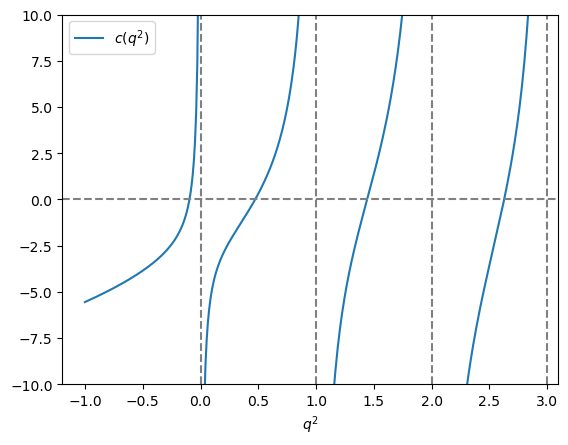

In [5]:
qSQ_set = np.linspace(-1.001, 3.001, 400)
zeta_set = []
for qSQ in qSQ_set:
    zeta_set.append(zeta_function(qSQ))
zeta_set = np.array(zeta_set)
zeta_set[np.abs(zeta_set) > 20] = np.nan
plt.plot(qSQ_set, zeta_set)
for qSQ_asymptote in range(4):
    plt.axvline(qSQ_asymptote, color='0.5', linestyle='--')
plt.legend(['$c(q^2)$'])
plt.xlabel('$q^2$')
plt.axhline(0, color='0.5', linestyle='--')
plt.ylim(-10, 10)

In [6]:
# form nearest neighbor differences of zeta_set
zeta_diff_set = np.diff(zeta_set)/np.diff(qSQ_set)
qSQ_set_for_diff = (qSQ_set[1:]+qSQ_set[:-1])/2

(-50.0, 50.0)

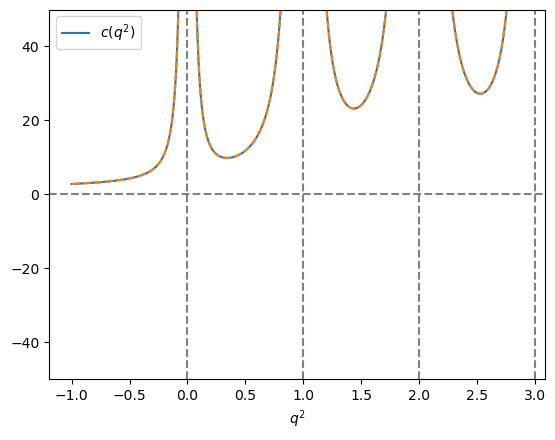

In [7]:
qSQ_set = np.linspace(-1.001, 3.001, 600)
zeta_set_der = []
for qSQ in qSQ_set:
    zeta_set_der.append(zeta_function_der(qSQ, cut=10, alpha=0.01))
zeta_set_der = np.array(zeta_set_der)
zeta_set_der[np.abs(zeta_set_der) > 60] = np.nan
plt.plot(qSQ_set, zeta_set_der)
plt.plot(qSQ_set_for_diff, zeta_diff_set, linestyle='--')
for qSQ_asymptote in range(4):
    plt.axvline(qSQ_asymptote, color='0.5', linestyle='--')
plt.legend(['$c(q^2)$'])
plt.xlabel('$q^2$')
plt.axhline(0, color='0.5', linestyle='--')
plt.ylim(-50, 50)

In [8]:
# Now we consider a high precision determination of the root near 0.5 using root_scalar
from scipy.optimize import root_scalar
def get_root(cut, alpha):
    return root_scalar(zeta_function, args=(cut, alpha), bracket=[0.4, 0.6])

In [9]:
cut = 10
print(zeta_function(0.4, cut, 0.5))
print(zeta_function(0.6, cut, 0.5))
print(get_root(cut, 0.5))

-0.7736132508214273
1.6602759094461566
      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.47289424745668485


In [10]:
def get_root_automated(iterations=50):
    alpha = 0.5
    cut = 10
    root = get_root(cut, alpha).root
    returned_root = root
    increasing_cut = True
    tolerence = 1e-10
    saved_values = []
    for i in range(iterations):
        if increasing_cut:
            cut += 1
            root_tmp = get_root(cut, alpha).root
            if np.abs(root_tmp-root) < tolerence:
                increasing_cut = False
                saved_values.append([root_tmp, cut, alpha])
                returned_root = root_tmp
            root = root_tmp
        else:
            alpha = alpha/2.
            root_tmp = get_root(cut, alpha).root
            if np.abs(root_tmp-root) > tolerence:
                increasing_cut = True
    saved_values = np.array(saved_values)
    return returned_root, saved_values

In [11]:
root_final, saved_values = get_root_automated()
print(root_final)
print(saved_values)

0.4728942473179055
[[4.72894247e-01 1.10000000e+01 5.00000000e-01]
 [4.72894247e-01 1.30000000e+01 2.50000000e-01]
 [4.72894247e-01 1.80000000e+01 6.25000000e-02]
 [4.72894247e-01 2.50000000e+01 3.12500000e-02]
 [4.72894247e-01 3.60000000e+01 1.56250000e-02]
 [4.72894247e-01 5.00000000e+01 7.81250000e-03]]


In [12]:
def get_der_at_root_automated(root_final=0.4728942473179055,
                              iterations=50):
    alpha = 0.5
    cut = 10
    value = zeta_function_der(root_final, cut, alpha)
    returned_value = value
    increasing_cut = True
    tolerence = 1e-10
    saved_values = []
    for i in range(iterations):
        if increasing_cut:
            cut += 1
            value_tmp = zeta_function_der(root_final, cut, alpha)
            if np.abs(value_tmp-value) < tolerence:
                increasing_cut = False
                saved_values.append([value_tmp, cut, alpha])
                returned_value = value_tmp
            value = value_tmp
        else:
            alpha = alpha/2.
            value_tmp = zeta_function_der(root_final, cut, alpha)
            if np.abs(value_tmp-value) > tolerence:
                increasing_cut = True
    saved_values = np.array(saved_values)
    return returned_value, saved_values

In [13]:
# In the outpoot below the first entry is the root, the second the
# cutoff and the third is alpha. For a fixed alpha the cutoff is incremented
# until the relative change drops below a given threshold. Then alpha is
# halved and the cutoff is incremented again.
get_der_at_root_automated()

(11.21475153021641,
 array([[1.12147515e+01, 1.10000000e+01, 5.00000000e-01],
        [1.12147515e+01, 1.30000000e+01, 2.50000000e-01],
        [1.12147515e+01, 1.80000000e+01, 6.25000000e-02],
        [1.12147515e+01, 2.50000000e+01, 3.12500000e-02],
        [1.12147515e+01, 3.40000000e+01, 1.56250000e-02],
        [1.12147515e+01, 4.70000000e+01, 7.81250000e-03]]))